In [11]:
import os
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torchvision
import numpy as np
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image, ImageFont, ImageDraw

from matplotlib  import pyplot as plt

In [12]:
num_epoch = 100
batch_size = 100

dir_name = "saved_img"

In [13]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [14]:
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)])  # 0~1 범위를 -1~1로 변경

train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True,
                                           transform=transform_train,
                                           download=True)

train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [15]:
latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear1 = nn.Linear(latent_dim, 128)
        self.linear2 = nn.Linear(128,512)
        self.linear3 = nn.Linear(512, 1024)
        self.linear4 = nn.Linear(1024, 1*28*28)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        x = self.tanh(x)
        return x

In [16]:
# Define discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.linear1 = nn.Linear(1*28*28, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 128)
        self.linear4 = nn.Linear(128, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.linear1(x))
        x = self.leaky_relu(self.linear2(x))
        x = self.leaky_relu(self.linear3(x))
        x = self.linear4(x)
        x = self.sigmoid(x)
        return x

In [18]:
D_model = Discriminator().to(device)
G_model = Generator().to(device)

# Loss function & Optimizer setting
loss_func = nn.BCELoss()
D_optimizer = torch.optim.Adam(D_model.parameters(), lr=0.0002)
G_optimizer = torch.optim.Adam(G_model.parameters(), lr=0.0002)


In [19]:
D_model_loss_list = []
G_model_loss_list = []

In [20]:
for epoch in range(num_epoch):
    sum_of_D_loss = 0.0
    sum_of_G_loss = 0.0
    
    for i, (images, label) in enumerate(train_data_loader):

        # make ground truth (labels) -> 1 for real, 0 for fake
        real_label = torch.full((batch_size, 1), 1, dtype=torch.float32).to(device)
        fake_label = torch.full((batch_size, 1), 0, dtype=torch.float32).to(device)

        real_images = images.reshape(batch_size, -1).to(device)  # reshape real images from MNIST dataset
        
        # G_model train
        G_optimizer.zero_grad()
        D_optimizer.zero_grad()

        z = torch.randn(batch_size, latent_dim).to(device)  # make fake images vector
        fake_images = G_model(z)
    
        # G_model backpropagation
        g_loss = loss_func(D_model(fake_images), real_label)
        g_loss.backward()
        G_optimizer.step()

        # D_model train
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = G_model(z)

        # real image, fake image의 loss 
        fake_loss = loss_func(D_model(fake_images), fake_label)
        real_loss = loss_func(D_model(real_images), real_label)
        
        # D_model backpropagation
        d_loss = (fake_loss + real_loss) / 2     # D_model loss
        d_loss.backward()
        D_optimizer.step()

        D_model_performance = D_model(real_images).mean()
        G_model_performance = D_model(fake_images).mean()
        
        sum_of_D_loss += d_loss
        sum_of_G_loss += g_loss

        if (i + 1) % 300 == 0:
            print("Epoch [ {}/{} ]  Step [ {}/{} ]  d_loss : {:.5f}  g_loss : {:.5f}"
                  .format(epoch + 1, num_epoch, i+1, len(train_data_loader), d_loss.item(), g_loss.item()))

    print("{} Epoch => D_model : {:.5f}  G_model : {:.5f}"
          .format(epoch + 1, D_model_performance, G_model_performance))
    
    D_model_loss_list.append(sum_of_D_loss/len(train_data_loader))
    G_model_loss_list.append(sum_of_G_loss/len(train_data_loader))

    # Save fake images in each epoch
    samples = fake_images.reshape(batch_size, 1, 28, 28)
    save_image(samples, os.path.join(dir_name, 'GAN_sample_img_{}.png'.format(epoch + 1)))

Epoch [ 1/100 ]  Step [ 300/600 ]  d_loss : 0.04088  g_loss : 3.28514
Epoch [ 1/100 ]  Step [ 600/600 ]  d_loss : 0.38444  g_loss : 9.04184
1 Epoch => D_model : 0.90764  G_model : 0.00004
Epoch [ 2/100 ]  Step [ 300/600 ]  d_loss : 0.35299  g_loss : 3.02030
Epoch [ 2/100 ]  Step [ 600/600 ]  d_loss : 0.46239  g_loss : 1.27641
2 Epoch => D_model : 0.77354  G_model : 0.33540
Epoch [ 3/100 ]  Step [ 300/600 ]  d_loss : 0.94126  g_loss : 0.79642
Epoch [ 3/100 ]  Step [ 600/600 ]  d_loss : 0.11702  g_loss : 2.82486
3 Epoch => D_model : 0.90432  G_model : 0.05211
Epoch [ 4/100 ]  Step [ 300/600 ]  d_loss : 0.48301  g_loss : 1.64301
Epoch [ 4/100 ]  Step [ 600/600 ]  d_loss : 0.41331  g_loss : 2.01696
4 Epoch => D_model : 0.74762  G_model : 0.16005
Epoch [ 5/100 ]  Step [ 300/600 ]  d_loss : 0.58722  g_loss : 2.09464
Epoch [ 5/100 ]  Step [ 600/600 ]  d_loss : 0.05877  g_loss : 3.15630
5 Epoch => D_model : 0.94348  G_model : 0.04301
Epoch [ 6/100 ]  Step [ 300/600 ]  d_loss : 0.10921  g_loss 

Epoch [ 44/100 ]  Step [ 600/600 ]  d_loss : 0.15744  g_loss : 3.02957
44 Epoch => D_model : 0.90106  G_model : 0.08531
Epoch [ 45/100 ]  Step [ 300/600 ]  d_loss : 0.22551  g_loss : 2.49152
Epoch [ 45/100 ]  Step [ 600/600 ]  d_loss : 0.19331  g_loss : 2.79723
45 Epoch => D_model : 0.86793  G_model : 0.07177
Epoch [ 46/100 ]  Step [ 300/600 ]  d_loss : 0.26812  g_loss : 2.71760
Epoch [ 46/100 ]  Step [ 600/600 ]  d_loss : 0.29418  g_loss : 2.06871
46 Epoch => D_model : 0.84148  G_model : 0.17088
Epoch [ 47/100 ]  Step [ 300/600 ]  d_loss : 0.34188  g_loss : 2.19562
Epoch [ 47/100 ]  Step [ 600/600 ]  d_loss : 0.36493  g_loss : 2.59593
47 Epoch => D_model : 0.75802  G_model : 0.13743
Epoch [ 48/100 ]  Step [ 300/600 ]  d_loss : 0.33666  g_loss : 2.20435
Epoch [ 48/100 ]  Step [ 600/600 ]  d_loss : 0.32856  g_loss : 2.53338
48 Epoch => D_model : 0.79295  G_model : 0.17480
Epoch [ 49/100 ]  Step [ 300/600 ]  d_loss : 0.28355  g_loss : 2.44543
Epoch [ 49/100 ]  Step [ 600/600 ]  d_loss : 

Epoch [ 87/100 ]  Step [ 600/600 ]  d_loss : 0.44847  g_loss : 1.32846
87 Epoch => D_model : 0.71981  G_model : 0.30559
Epoch [ 88/100 ]  Step [ 300/600 ]  d_loss : 0.42999  g_loss : 1.37394
Epoch [ 88/100 ]  Step [ 600/600 ]  d_loss : 0.49100  g_loss : 1.85531
88 Epoch => D_model : 0.68479  G_model : 0.23622
Epoch [ 89/100 ]  Step [ 300/600 ]  d_loss : 0.44823  g_loss : 1.41535
Epoch [ 89/100 ]  Step [ 600/600 ]  d_loss : 0.50384  g_loss : 1.11154
89 Epoch => D_model : 0.72930  G_model : 0.35177
Epoch [ 90/100 ]  Step [ 300/600 ]  d_loss : 0.51958  g_loss : 1.43792
Epoch [ 90/100 ]  Step [ 600/600 ]  d_loss : 0.51245  g_loss : 1.55771
90 Epoch => D_model : 0.72554  G_model : 0.37198
Epoch [ 91/100 ]  Step [ 300/600 ]  d_loss : 0.47226  g_loss : 1.76629
Epoch [ 91/100 ]  Step [ 600/600 ]  d_loss : 0.52659  g_loss : 1.20673
91 Epoch => D_model : 0.66318  G_model : 0.31051
Epoch [ 92/100 ]  Step [ 300/600 ]  d_loss : 0.45374  g_loss : 1.30701
Epoch [ 92/100 ]  Step [ 600/600 ]  d_loss : 

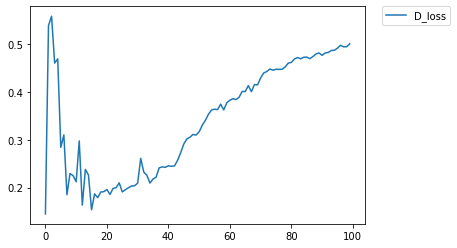

In [21]:
plt.plot(D_model_loss_list, label='D_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

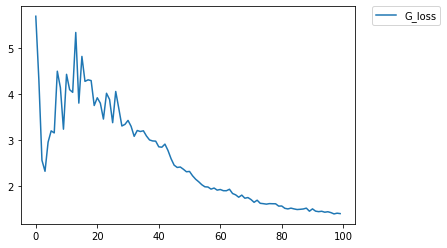

In [22]:
plt.plot(G_model_loss_list, label='G_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

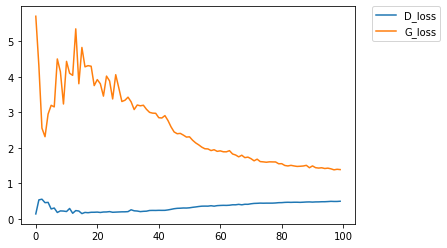

In [23]:
plt.plot(D_model_loss_list, label='D_loss')
plt.plot(G_model_loss_list, label='G_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()